## Feature Extaction Test

In [1]:
import sys
sys.path.insert(0, '..')
from metrics.metrics import  quick_circle_comparison, circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction, CandidatesFeatureExtraction_MP
from database.dataset import *
import feature_extraction.haar_features.haar_modules as hm

import pickle

### Database initialization

In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

### Detectors Parameters and initialization

In [3]:
hd = MorphologyCalcificationDetection(rbd_img_path='/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/new_rbd',
                                      threshold=0.96, min_distance=6,
                                      area=14*14, filter_muscle_region=True, )
CENTER_CROP_PATCH = None
PATCH_SIZE = 14

GABOR_PARAMS = {'scale': 2, 'orientation': 3,
                'max_freq': 0.2, 'ksize': (20, 20), 'sigma': 3}
WAVELET_PARAMS = {'angles': [0, np.pi/4, np.pi/2]}


# THIS IS FINAL HAAR
path = (Path.cwd().parent)
with open(path/'data/final_haar_400_feat_selection_GSM.p', 'rb') as f:
    selection = pickle.load(f)
    
# ISTANTIATE the candidate Feature Extractor with the selected features.
haar_params = {
    'skimage': {
        'feature_type': selection['skimage_haar_feature_types_sel'],
        'feature_coord': selection['skimage_haar_feature_coords_sel']
    },
    'ours': {
        'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
        'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
        'rotated_feature_types': None,
        'horizontal_feature_types': None
    },
    'patch_size': 14
}

cfe = CandidatesFeatureExtraction_MP(patch_size=PATCH_SIZE, fos=False, gabor_params=None,
                                  wavelet_params=None, haar_params=haar_params)

### Detector initialization

In [6]:
db_range = list(range(len(db)))

### FE

In [8]:
fdf = []
fns_df = []
for idx in tqdm(db_range[:]):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']
    # candidate selection
    candidates = hd.detect(image, image_id, muscle_mask)

    # labeling of candidates:
    tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
    
    # Extracting features
    labels = np.where(candidates.label.values == 'TP', True, False)
    
    # Avoid extracting features for repeted detections
    X = candidates.drop_duplicates(subset='repeted_idxs')
    X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

    # Get features dfs
    X = pd.DataFrame(data=X, columns=cfe.feature_names)
    X.index = candidates.drop_duplicates(subset='repeted_idxs').index

    res = X.loc[candidates.repeted_idxs.tolist(),:]
    res['img_id'] = image_id
    res['repeted_idxs'] = candidates.repeted_idxs.tolist()
    res['matching_gt'] = candidates.matching_gt.tolist()
    res['label'] = labels

    # Generate a fn dataframe to compute frocs
    fn['img_id'] = image_id
    fns_df.append(fn)
    fdf.append(res)
    
data = pd.concat(fdf, ignore_index=True)
fns_df = pd.concat(fns_df, ignore_index=True)


100%|██████████| 210/210 [17:09<00:00,  4.90s/it]


In [9]:
pd.to_pickle((data, fns_df), 'feature_sets/gmorph_HaarF_final.pkl')

# REST

In [9]:
hd = HoughCalcificationDetection()

In [11]:
fdf = []
fns_df = []
for idx in tqdm([130]):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']
    # candidate selection
    candidates = hd.detect(image, image_id, load_processed_images=True,
                           hough2=False, muscle_mask=muscle_mask)[0]

    # labeling of candidates:
    tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
    
    # Extracting features
    labels = np.where(candidates.label.values == 'TP', True, False)
    
    # Avoid extracting features for repeted detections
    X = candidates.drop_duplicates(subset='repeted_idxs')
    X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

    # Get features dfs
    X = pd.DataFrame(data=X, columns=cfe.feature_names)
    X.index = candidates.drop_duplicates(subset='repeted_idxs').index

    res = X.loc[candidates.repeted_idxs.tolist(),:]
    res['img_id'] = image_id
    res['repeted_idxs'] = candidates.repeted_idxs.tolist()
    res['matching_gt'] = candidates.matching_gt.tolist()
    res['label'] = labels

    # Generate a fn dataframe to compute frocs
    fn['img_id'] = image_id
    fns_df.append(fn)
    fdf.append(res)
    
data = pd.concat(fdf, ignore_index=True)
fns_df = pd.concat(fns_df, ignore_index=True)


100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


In [15]:
data['str_cand_coord'] = data.candidate_coordinates.astype(str)
data[data.str_cand_coord == '[451, 1182, 5]']

,haar_0,haar_1,haar_2,haar_3,haar_4,haar_5,haar_6,haar_7,haar_8,haar_9,...,rot_haar_168,rot_haar_169,rot_haar_170,candidate_coordinates,patch_coordinates,img_id,repeted_idxs,matching_gt,label,str_cand_coord
109,0.005346,0.069494,0.066999,-0.108339,0.125802,0.013899,0.064148,-0.075552,0.01675,0.040627,...,1.286529,-3.312901,2.127227,"[451, 1182, 5]","((1175, 1189), (444, 458))",50994895,109,4.0,True,"[451, 1182, 5]"


In [16]:
tp

,x,y,radius,label,repeted_idxs,matching_gt
0,400,1189,8,TP,0,4
1,426,1187,9,TP,1,4
2,443,1316,8,TP,2,4
3,318,766,9,TP,3,5
4,363,847,9,TP,4,2
...,...,...,...,...,...,...
127,477,1194,5,TP,127,4
128,489,1247,4,TP,128,4
129,481,1206,3,TP,129,4
130,464,1228,4,TP,130,4


In [17]:
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
image_mask = db_sample['lesion_mask']
muscle_mask = db_sample['muscle_mask']
# candidate selection
candidates = hd.detect(image, image_id, load_processed_images=True,
                        hough2=False, muscle_mask=muscle_mask)[0]

# labeling of candidates:
tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
    candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)

In [21]:
tp[tp.x == 451]

,x,y,radius,label,repeted_idxs,matching_gt
109,451,1182,5,TP,109,4


In [ ]:
get_tp_fp_fn_center_patch_criteria(
    candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)

In [29]:
candidates[candidates[:,0] == 451]

array([[ 451, 1182,    5],
       [ 451,  907,    9]])

In [30]:
# labeling of candidates:
tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
    candidates[candidates[:,0] == 451], image_mask, CENTER_CROP_PATCH, PATCH_SIZE)

In [32]:
tp

,x,y,radius,label,repeted_idxs,matching_gt
0,451,1182,5,TP,0,4


In [38]:
image_mask[1175:1189, 444:458]

array([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]], dtype=uint8)

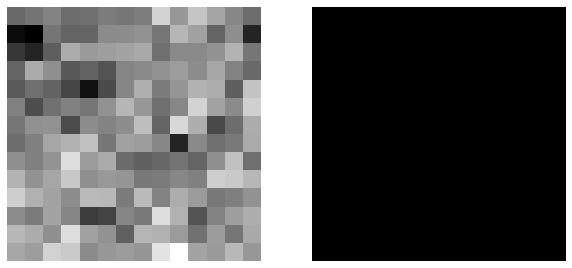

In [37]:
simple_im_show2(image[1175:1189, 444:458], image_mask[1175:1189, 444:458]>0)

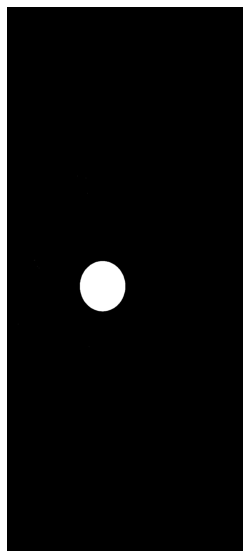

In [44]:
simple_im_show(image_mask>0)

In [ ]:
pd.to_pickle((all_data_df, fns_df), 'feature_sets/hough2_all_feat_1pxsize.pkl')

# Test|

In [4]:
cfe = CandidatesFeatureExtraction(patch_size=PATCH_SIZE, fos=True, gabor_params=GABOR_PARAMS,
                                  wavelet_params=WAVELET_PARAMS, haar_params=None)

cfe_mp = CandidatesFeatureExtraction_MP(patch_size=PATCH_SIZE, fos=True, gabor_params=GABOR_PARAMS,
                                  wavelet_params=WAVELET_PARAMS, haar_params=None)


hd = HoughCalcificationDetection()


In [5]:
idx = 0
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
image_mask = db_sample['lesion_mask']

# candidate selection
candidates = hd.detect(image, image_id, load_processed_images=True, hough2=True)[1]

    # labeling of candidates:
tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
    candidates, image_mask, None, PATCH_SIZE)

In [6]:
len(candidates)

1776

In [7]:
# feature extraction
X = cfe.extract_features(candidates, image)
res = pd.DataFrame(X, columns=cfe.feature_names)

In [9]:
cfe_mp.n_jobs = 8
# feature extraction
X2 = cfe_mp.extract_features(candidates, image)
res2 = pd.DataFrame(X2, columns=cfe_mp.feature_names)